## PreTrain a BERT model via MLM
Before this, the data must be processed, tokenized and prepared:
1. `data_processing` notebook loads raw data and prepares training, validation and test dataset
2. `data_tokenizer`notebook tokenizes the data using LiPCoT model
3. `data_prepare` notebook prepares datasets for BERT models

Here, we will use training and validation dataset for pretraining.
### 1. Import libraries

In [1]:
import os
import joblib
from modules.bert_module import *
from modules.path_module import *
from transformers import BertTokenizer
from hugtokencraft import editor # type: ignore
from transformers import BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling, DataCollatorForWholeWordMask
from torch import cuda
from torchinfo import summary
import torch
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import pandas as pd
from transformers import pipeline
import math

### 2. Load Training and Validation dataset

In [2]:
lipcot_model=joblib.load(os.path.join(lipcot_model_savepath,"lipcot_model.joblib"))
tokenizer=editor.load_tokenizer(BertTokenizer,lipcot_model['tokenizer_path'])

train_dataset=joblib.load( os.path.join(bert_datapath,"train_data.joblib"))
val_dataset=joblib.load( os.path.join(bert_datapath,"val_data.joblib"))


Tokenization model Validation: Passed

Tokenizer loaded with vocabulary size: 69


### 3. Configure and initialize BERT model  

In [3]:
max_sentence_length=lipcot_model['model_max_length']-2

config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=256, 
    num_hidden_layers=6, 
    num_attention_heads=2,
    output_hidden_states=True,
    position_embedding_type="relative_key",#"relative_key","absolute"
    max_position_embeddings=max_sentence_length+2 # specifies the maximum number of tokens in a sequence. maybe this is sentence_length? 8=6 words+2 special tokens
)
 
model = BertForMaskedLM(config)
model.resize_token_embeddings()

Embedding(69, 256, padding_idx=0)

Let's see a model summary:

In [4]:
#from torchview import draw_graph
#model_graph = draw_graph(model, input_data=(512,2)).visual_graph

# Create a sample input tensor and move it to the same device as the model
input_tensor = torch.tensor([[1, 2, 3]], dtype=torch.int, device=model.device)

print('No of parameters: ', model.num_parameters())
summary(model, input_size=(1, max_sentence_length+2), dtypes=[input_tensor.dtype])


No of parameters:  11355973


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                  Output Shape              Param #
BertForMaskedLM                                         [1, 128, 256]             --
├─BertModel: 1-1                                        [1, 128, 256]             --
│    └─BertEmbeddings: 2-1                              [1, 128, 256]             32,768
│    │    └─Embedding: 3-1                              [1, 128, 256]             17,664
│    │    └─Embedding: 3-2                              [1, 128, 256]             512
│    │    └─LayerNorm: 3-3                              [1, 128, 256]             512
│    │    └─Dropout: 3-4                                [1, 128, 256]             --
│    └─BertEncoder: 2-2                                 [1, 128, 256]             --
│    │    └─ModuleList: 3-5                             --                        11,238,144
├─BertOnlyMLMHead: 1-2                                  [1, 128, 69]              --
│    └─BertLMPredictionHead: 2-3          

### 4. Configure training process

In [5]:
# use GPU
device='cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()
model.to(device)
#data_collator = DataCollatorForLanguageModeling(
#    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
#)
data_collator = DataCollatorForWholeWordMask(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(
    output_dir=bert_modelpath,
    overwrite_output_dir=True,
    num_train_epochs=256,
    per_device_train_batch_size=2,
    #save_steps=-1,
    save_total_limit=15,
    push_to_hub=False,
    #learning_rate=5e-10,
    warmup_steps=100,
    weight_decay=0.01,
    do_train=True,
    do_eval=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='loss', 
    greater_is_better=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

#print(training_args)

Running on: cuda


### 5. Train BERT

In [6]:
%%capture

trainer.train()

There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


Let's inspect the training process

Steps taken: 41000


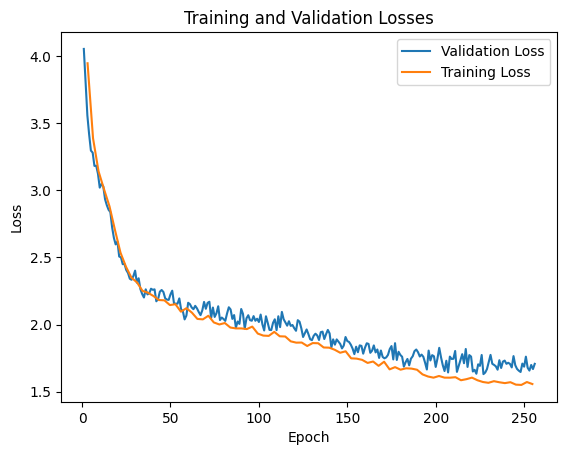

In [7]:
global_steps_taken=trainer._globalstep_last_logged
print("Steps taken: "+str(global_steps_taken))

t_history=pd.DataFrame(trainer.state.log_history)

# Get the training and evaluation losses
train_losses, training_step=get_trainer_history(t_history,'loss')
eval_losses , eval_step=get_trainer_history(t_history,'eval_loss')


# Plot the losses
plt.figure
plt.plot(eval_step,eval_losses, label="Validation Loss")
plt.plot(training_step,train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale('log')  # Set y-axis to log scale
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

Now let's calculate model's perplexity

In [8]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}") 

  0%|          | 0/18 [00:00<?, ?it/s]

Perplexity: 5.37


Finally, let's inspect model's layers

In [9]:
# Input text
input_text = train_dataset.texts[0]
input_ids = tokenizer.encode(input_text, add_special_tokens=True)
input_ids = torch.tensor([input_ids], dtype=torch.int, device=model.device)

model.eval()
# Forward pass through the model to get outputs and attentions
with torch.no_grad():
    outputs = model(input_ids)

all_hidden_states =outputs.hidden_states
all_hidden_states=list(all_hidden_states)# all hidden states as list:  batch=1,words=6+2,hidden size=4
last_hidden_states=all_hidden_states[0] # batch=1,words=6+2,hidden size
last_hidden_states=last_hidden_states.detach().cpu().numpy()
last_hidden_states=last_hidden_states.squeeze()
print(last_hidden_states.shape) 
#print(last_hidden_states) 

# Get the attentions from the outputs
attentions = outputs.attentions

if attentions is not None:
    # Print the shape of the attentions
    print("Number of attention layers:", len(attentions))
    for i, attention_layer in enumerate(attentions):
        print(f"Shape of attention layer {i+1}:", attention_layer.shape)
else:
    print("Attention is None")

(61, 256)
Attention is None


### 7. Save PreTrained Model

In [10]:
trainer.save_model(bert_modelpath)

Let's cleanup the checkpoints

In [11]:
import os
import shutil

checkpoint_dirs = [d for d in os.listdir(bert_modelpath) if d.startswith('checkpoint')]

# Delete each checkpoint directory
for checkpoint_dir in checkpoint_dirs:
    shutil.rmtree(os.path.join(bert_modelpath, checkpoint_dir))

print("All checkpoints have been deleted.")

All checkpoints have been deleted.


## Model Performance in MLM
Let us see the model's performance in masked tokens.

### 1. Load Bert model

In [12]:
model = BertForMaskedLM.from_pretrained(bert_modelpath)
model.to(device)
print('Bert Model Loaded')

Bert Model Loaded


### 2. Make masked token prediction and calculate error

c:\Users\fahim\anaconda3\envs\mybertV2\lib\site-packages\transformers\pipelines\base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


6.832298136645963


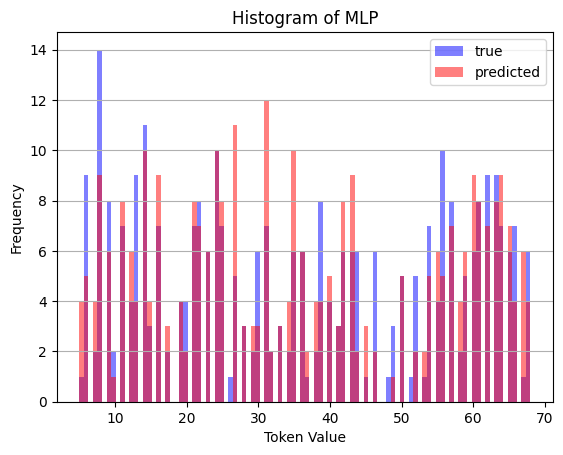

14.492753623188406


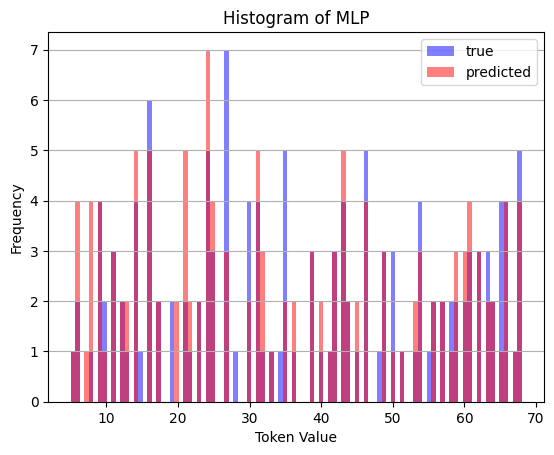

Top 5 solutions
Training error: 6.832298136645963
val error: 14.492753623188406


In [13]:
top_k_val=5
fill_mask = pipeline(
    "fill-mask",
    model=model,
    top_k=top_k_val,
    tokenizer=tokenizer,
    device=0 # Setting this to -1 will leverage CPU, >=0 will run the model on the associated CUDA 
)


train_data_for_perf=get_txt_from_dataset(tokenizer, train_dataset)
val_data_for_perf=get_txt_from_dataset(tokenizer, val_dataset)

train_error_rate, train_masked_tokens, train_predicted_tokens= get_mask_error(train_data_for_perf,fill_mask,tokenizer)
val_error_rate, val_masked_tokens, val_predicted_tokens= get_mask_error(val_data_for_perf,fill_mask,tokenizer)

print(f"Top {top_k_val} solutions")
print("Training error: "+str(train_error_rate))
print("val error: "+str(val_error_rate))



Let's measure on test set

c:\Users\fahim\anaconda3\envs\mybertV2\lib\site-packages\transformers\pipelines\base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


9.782608695652174


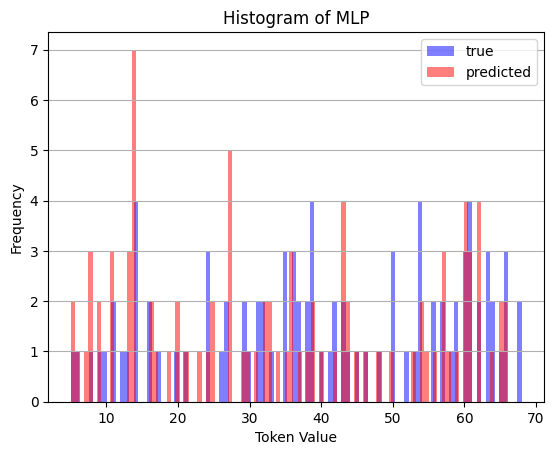

Top 5 solutions
Training error: 9.782608695652174


In [14]:
test_dataset=joblib.load( os.path.join(bert_datapath,"test_data.joblib"))
test_data_for_perf=get_txt_from_dataset(tokenizer, test_dataset)

test_error_rate, test_masked_tokens, test_predicted_tokens= get_mask_error(test_data_for_perf,fill_mask,tokenizer)

print(f"Top {top_k_val} solutions")
print("Training error: "+str(test_error_rate))
